In [7]:
import json
import pandas as pd
import numpy as np

import os
import datetime
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.imagenet_utils import decode_predictions
import matplotlib.pyplot as plt
from PIL import Image

from sklearn.model_selection import train_test_split
from keras.utils import to_categorical

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation, InputLayer, Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU

from keras.initializers import glorot_normal

import math
from keras.datasets import cifar100
from scipy.cluster.vq import whiten

import glob
import os

%matplotlib inline

<font color="red">CUt out images instead of spreading them </font>

In [8]:
def load_image(filename, img_rows=100, img_cols=100, plot=True):
    try:
        # load an image in PIL format
        original = load_img(filename, target_size=(img_rows, img_cols))

        # convert the PIL image to a numpy array
        # IN PIL - image is in (width, height, channel)
        # In Numpy - image is in (height, width, channel)
        numpy_image = img_to_array(original)

        # Convert the image / images into batch format
        # expand_dims will add an extra dimension to the data at a particular axis
        # We want the input matrix to the network to be of the form (batchsize, height, width, channels)
        # Thus we add the extra dimension to the axis 0.
        image_batch = np.expand_dims(numpy_image, axis=0)
        if plot: plt.imshow(np.uint8(image_batch[0]))
        return image_batch
    except IOError:
        # image_list.remove(filename)
        print("removed")
        return np.array([])

In [37]:
def fetch_data (file_path, img_rows=100, img_cols=100, cutoff=-1):
    # 2. Auto-iterate using the query syntax
    #    https://developers.google.com/drive/v2/web/search-parameters
    
    # file_list = glob.glob("./data/input/" + file_path + "/*.JPEG")
    file_list = glob.glob(file_path + "/*.JPEG")
  
    final_images = []
    batches = []
    for f in file_list[0:cutoff]:
        curr_image = load_image(f, img_rows, img_cols)
        if curr_image.size != 0:
            final_images.append(f)
            batches.append(curr_image)
    batches = [b[0] for b in batches]
    return final_images, np.array(batches)

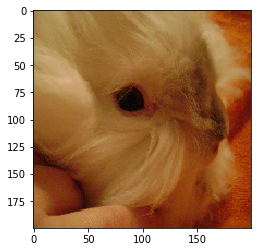

In [11]:
img_rows, img_cols = 200, 200
input_path = "351_Data\\ILSVRC2012_Validation\\"
final_images, batches = fetch_data(input_path + "images", img_rows, img_cols, cutoff=10)

In [12]:
image_ids = [int(f.split("_")[-1].split(".JPEG")[0]) - 1 for f in final_images]

In [13]:
labels = np.array(pd.read_csv("351_Data\ILSVRC2012_Validation\labels\ILSVRC2012_devkit_t12\data\ILSVRC2012_validation_ground_truth.txt", header=None, names=["Class"]))

In [14]:
curr_labels = labels [image_ids]

In [15]:
curr_labels

array([[490],
       [361],
       [171],
       [822],
       [297],
       [482],
       [ 13],
       [704],
       [599],
       [164]], dtype=int64)

# Neural network test

In [16]:
x_train, x_test, y_train, y_test = train_test_split(batches, curr_labels, test_size=0.25)

In [17]:
def format_data(x_train, x_test):
    x_train = x_train.astype('float32')/255.
    x_test = x_test.astype('float32')/255.
    return x_train, x_test

In [18]:
x_train, x_test = format_data(x_train, x_test)

Does Whitening work when it is done independently on x_train and x_test? (e.g., should the same whitening factor be used on x_test as on x_train)

In [19]:
def filter_for_classes(X, y, classes):
    mask = np.isin(y, classes)
    mask = mask.reshape(len(mask))
    return X[mask], y[mask]

In [20]:
classes_to_retain = range(0,1000)
num_classes = len(classes_to_retain)
x_train, y_train = filter_for_classes(x_train, y_train, classes_to_retain)
x_test, y_test = filter_for_classes(x_test,y_test,classes_to_retain)

In [21]:
x_train.shape

(7, 200, 200, 3)

In [22]:
def whiten_data(x_train, x_test):
    X = np.append(x_train, x_test, axis=0)
    X_white = whiten(X).reshape(X.shape)
    x_train_white = X_white[0:x_train.shape[0]]
    x_test_white = X_white[x_train.shape[0]:x_train.shape[0]+x_test.shape[0]]
    return x_train_white, x_test_white

In [23]:
x_train, x_test = whiten_data(x_train,x_test)

I actually think most of the reshaping above is unnecessary because we actually need a 50000, 3\*32\*32 shape

In [24]:
y_train_categorical = to_categorical(y_train)
y_test_categorical = to_categorical(y_test)
# y_val_categorical = to_categorical(y_val)

In [25]:
datagen = keras.preprocessing.image.ImageDataGenerator(featurewise_center=False, samplewise_center=False, featurewise_std_normalization=False, samplewise_std_normalization=False, zca_whitening=False, zca_epsilon=1e-06, rotation_range=0.0, width_shift_range=0.0, height_shift_range=0.0, shear_range=0.0, zoom_range=0.0, channel_shift_range=0.0, fill_mode='nearest', cval=0.0, horizontal_flip=False, vertical_flip=False, rescale=None, preprocessing_function=None, data_format=None)


In [26]:
# compute quantities required for featurewise normalization
# (std, mean, and principal components if ZCA whitening is applied)
datagen.fit(x_train)

## Model Definition

I will start by "randomly" creating models.

In [27]:
from keras.applications import InceptionV3, Xception, InceptionResNetV2
from keras import Model
models = []
model_names = []
input_shape = x_train[0].shape

In [28]:
incpv3_model = InceptionV3(include_top=False, input_shape=input_shape)
models.append(incpv3_model)
model_names.append("InceptionV3")

In [29]:
xcep_model = Xception(include_top=False, input_shape=input_shape)
models.append(xcep_model)
model_names.append("Xception")

In [30]:
incepresnet_model = InceptionResNetV2(include_top=False, input_shape=input_shape)
models.append(incepresnet_model)
model_names.append("Inception ResNet")

In [31]:
for ind, model in enumerate(models):
    output = model.layers[-1].output
    output_ = Flatten()(output)
    # output = Dense(output_dim=1000, activation='relu')(output) # your newlayer Dense(...)
    models[ind] = Model(model.input, output_)

In [32]:
# lr = 0.001
# for model in models:
#     model.compile(loss=keras.losses.categorical_crossentropy,
#               optimizer=keras.optimizers.Adam(lr=lr),
#               metrics=['accuracy'])

In [33]:
now = datetime.datetime.now()
prefix = now.strftime("%Y%m%d_%H%M")

In [34]:
def create_output_files ():
    for model_ind, model in enumerate(models):
        pred_train = model.predict(x_train)
        pred_test = model.predict(x_test)
        pred_train_with_target = np.array([np.array([preds, y_train[i]]) for i,preds in enumerate(pred_train)])
        pred_test_with_target = np.array([np.array([preds, y_test[i]]) for i,preds in enumerate(pred_test)])
        path = input_path + "Intermediate\\" + prefix + "\\" + model_names[model_ind]
        if not os.path.exists(path):
            os.makedirs(path)
        np.save(path + "\\train", pred_train_with_target)
        np.save(path + "\\test", pred_test_with_target)

In [35]:
create_output_files()